In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing as preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import register_keras_serializable

from Code.utils.dataset import Dataset
import Code.utils.store_model as store_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
@register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=self.num_heads, key_dim=self.embed_dim
        )
        self.dense_proj = keras.Sequential([
            layers.Dense(self.dense_dim, activation="relu"),
            layers.Dense(self.embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        super().build(input_shape)

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


In [3]:
@register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def build(self, input_shape):
        self.token_embeddings = layers.Embedding(
            input_dim=self.input_dim, output_dim=self.output_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=self.sequence_length, output_dim=self.output_dim
        )
        super().build(input_shape)

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


In [4]:
# Load datasets

dataset = Dataset('../../Dataset/DatasetsGerados/dataset_training_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_training_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_validation_output.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_input.csv',
                  '../../Dataset/DatasetsGerados/dataset_test_output.csv')

X_train, y_train, X_validation, y_validation, X_test, y_test, ids = dataset.get_datasets_unprocessed('Text', 'Label', sep='\t', rem_punctuation=True)

max_words = 10000
max_len = 500

# print(X_train.iloc[0, 0])
# print(X_train.shape)

tokenizer = Tokenizer(num_words=max_words)  # limit to top max_words words
tokenizer.fit_on_texts(X_train.iloc[:, 0])

X_train = tokenizer.texts_to_sequences(X_train.iloc[:, 0])
X_validation = tokenizer.texts_to_sequences(X_validation.iloc[:, 0])
X_test = tokenizer.texts_to_sequences(X_test.iloc[:, 0])

X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_validation = preprocessing.sequence.pad_sequences(X_validation, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

# print(X_train[0])
# print(X_train.shape)

print(y_train)

[0 1 0 ... 0 1 0]


In [5]:
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(max_len, max_words, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["acc"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("full_transformer_encoder.keras",
                                    save_best_only=True)
]
history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs=3, callbacks=callbacks)
model = keras.models.load_model("full_transformer_encoder.keras", custom_objects={"TransformerEncoder": TransformerEncoder, "PositionalEmbedding": PositionalEmbedding})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding            │ (None, None, 256)      │     2,688,000 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, None, 256)      │       543,776 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,232,033 (12.33 MB)

 Trainable params: 3,232,033 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 110s 857ms/step - acc: 0.6700 - loss: 1.0018 - val_acc: 0.9860 - val_loss: 0.0665
Epoch 2/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 104s 827ms/step - acc: 0.9506 - loss: 0.1333 - val_acc: 0.9730 - val_loss: 0.0863
Epoch 3/3
126/126 ━━━━━━━━━━━━━━━━━━━━ 106s 843ms/step - acc: 0.9796 - loss: 0.0652 - val_acc: 0.9820 - val_loss: 0.0630


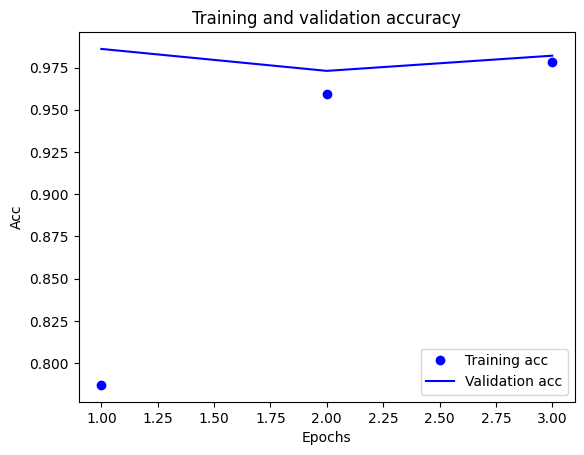

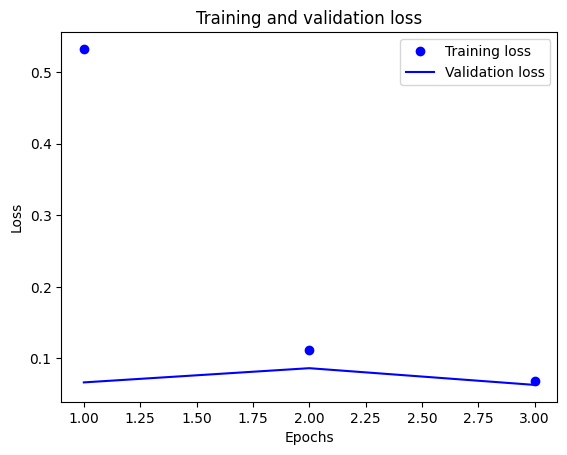

In [6]:
# Plot curves

history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Plot loss curves

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate Model

results = model.evaluate(X_test, y_test, verbose = 0)
print(results)

[0.08734476566314697, 0.9739999771118164]


In [8]:
# Predict output

output = model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step


In [9]:
# Store output

results_filepath = './Results/transformer_results.csv'

# Ensure the directory exists
os.makedirs(os.path.dirname(results_filepath), exist_ok=True)

results = dataset.merge_results(ids, output)
results.to_csv(results_filepath, sep='\t', index=False)

In [10]:
# Store network model

model_filepath = './Model/transformer'
model_key = 'transformer'

store_model.store_model(model_filepath, model_key, model)

In [11]:
# Retrieve network model

model_filepath = './Model/transformer'
model_key = 'transformer'

model = store_model.retrieve_model(model_filepath, model_key)